In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.utils import save_model, load_model

In [2]:
pd.set_option("display.max_rows", 100)

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

# Import dataset

In [4]:
df = pd.read_csv("data/production_upset.csv")
df.head()

,category,statement
0,Rotating Equipment,GTG-B loss power
1,Rotating Equipment,"At 2030 hrs, medium pressure compressor manual..."
2,Rotating Equipment,Serendah production lower than target due to m...
3,Rotating Equipment,MP Compressor not available since 19 Dec 2018 ...
4,Rotating Equipment,Medium Pressure Compressor offline until end J...


# Dataset splitting

In [5]:
X = df.statement
y = df.category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((251,), (63,), (251,), (63,))

In [6]:
# tidak perlu preprocessing

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer

# Preprocessing

In [7]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer(tokenizer= word_tokenize, stop_words= stopwords.words("english"))),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.5s finished
C:\Users\dharm\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


{'algo__C': 3.8672288491177538, 'algo__fit_intercept': False}
0.9880478087649402 0.7687416331994646 0.6507936507936508


In [8]:
save_model(model, "pred_cat.pkl")

Model is pickled as model/pred_cat.pkl


In [10]:
x = ["mp compressor down"]
model.predict(x)

array(['Rotating Equipment'], dtype=object)

# Prediction ke data test & membuat dummy production losses

In [9]:
prediction = pd.DataFrame(X_test)
prediction["true_category"] = y_test
prediction["predicted_category"] = model.predict(X_test)
prediction.head()

,statement,true_category,predicted_category
211,SERAMPANG wells shut-in & zero gas export whe...,External,External
286,KIKEH FTL02 pigging - 4th pig (Bi-Di) and 5th ...,Process,Process
292,KIKEH FTL01 pigging operation on going (receiv...,Operations,Operations
122,MERAPUH well MEPA-2RD and MEPA-10 remain shut-...,Operations,Well Related
189,SAPA High flaring suspected GOR for some of t...,Operations,Operations


In [26]:
prediction["losses"]= np.random.rand(len(prediction))

In [34]:
prediction.head()

,statement,true_category,predicted_category,losses
211,SERAMPANG wells shut-in & zero gas export whe...,External,External,0.037689
286,KIKEH FTL02 pigging - 4th pig (Bi-Di) and 5th ...,Process,Process,0.104766
292,KIKEH FTL01 pigging operation on going (receiv...,Operations,Operations,0.981246
122,MERAPUH well MEPA-2RD and MEPA-10 remain shut-...,Operations,Well Related,0.674022
189,SAPA High flaring suspected GOR for some of t...,Operations,Operations,0.163149


In [33]:
prediction.groupby("predicted_category").sum()

,losses
predicted_category,
External,0.037689
Operations,4.855846
Process,14.264007
Rotating Equipment,6.999267
Well Related,3.140267


# Menggunakan FastText

In [38]:
df = pd.read_csv('data/production_upset.csv')

In [39]:
df.head()

,category,statement
0,Rotating Equipment,GTG-B loss power
1,Rotating Equipment,"At 2030 hrs, medium pressure compressor manual..."
2,Rotating Equipment,Serendah production lower than target due to m...
3,Rotating Equipment,MP Compressor not available since 19 Dec 2018 ...
4,Rotating Equipment,Medium Pressure Compressor offline until end J...


# Encoding dengan menggunakan fast text

In [40]:
import os
from tqdm.auto import tqdm

from nltk.tokenize import word_tokenize
from gensim.models import FastText

In [41]:
# tokenisasi statement
sentences = [word_tokenize(text.lower()) for text in tqdm (df.statement)]
sentences[:5]

[['gtg-b', 'loss', 'power'],
 ['at',
  '2030',
  'hrs',
  ',',
  'medium',
  'pressure',
  'compressor',
  'manually',
  'stopped',
  'due',
  'to',
  'mechanical',
  'seal',
  'leak',
  'badly',
  '.'],
 ['serendah',
  'production',
  'lower',
  'than',
  'target',
  'due',
  'to',
  'medium',
  'pressure',
  'mechanical',
  'seal',
  'leaking',
  'issues',
  '.'],
 ['mp',
  'compressor',
  'not',
  'available',
  'since',
  '19',
  'dec',
  '2018',
  'and',
  'remains',
  'offline',
  'until',
  'further',
  'notice',
  '.',
  'well',
  'snpa-07',
  'choke',
  'back',
  'to',
  'reduced',
  'flaring',
  '.'],
 ['medium',
  'pressure',
  'compressor',
  'offline',
  'until',
  'end',
  'jan',
  '2019.',
  'well',
  'snpa-07',
  'choke',
  'back',
  'for',
  'flaring',
  'management',
  '.']]

# Train2Vec

In [42]:
# ukuran size = latent space = 16, 32, dll . Di industry size 100, sedang = 200, wikipedia =300
# window lihat ke kiri atau kekanan seberapa banyak
# min_count = berapa banyak kata yang muncul agar dijadikan word yang ditraining
#sg = skip gram , by default dia false
model = FastText(sentences, size = 128, window = 5, min_count =3 , workers = 4, iter = 1000, sg=0, hs = 0)

In [43]:
os.makedirs("model/fasttext/", exist_ok= True)
model.save("model/fasttext/upset_category.fasttext")

# Model information

In [44]:
w2v = model.wv

In [45]:
#w2v.index2word

# Klasifikasi

In [46]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [47]:
from nltk.tokenize import word_tokenize
from gensim.models import FastText

In [48]:
w2v = FastText.load("model/fasttext/upset_category.fasttext").wv

In [49]:
def norm_sent_vector(sentence, w2v_model):
    vecs = [w2v_model[word.lower()] for word in word_tokenize (sentence)]    
    norm_vecs = [vec/ np.linalg.norm(vec) for vec in vecs if np.linalg.norm(vec > 0)]
    sent_vec = np.mean (vecs, axis = 0) #dari arah baris
    return sent_vec

# Dataset splitting

In [50]:
vecs = [norm_sent_vector (sentence, w2v) for sentence in df.statement]
vecs = np.array(vecs)
vecs

array([[ 0.46465334,  0.18274505, -0.08704106, ...,  2.4630723 ,
        -0.11840254,  0.5428737 ],
       [-0.973747  , -0.23393252, -0.60138094, ..., -0.0870371 ,
         0.49163336,  0.7383808 ],
       [-0.8401642 ,  0.7123824 , -0.23061013, ..., -0.3260474 ,
         0.9262904 ,  0.7585281 ],
       ...,
       [-0.18852456, -0.27645552,  0.28851032, ..., -1.1835513 ,
         0.5444492 , -0.17833875],
       [ 0.15935971,  0.7599684 ,  0.9319441 , ..., -0.21528544,
         1.0763034 ,  1.036915  ],
       [-0.20216717,  1.4125469 ,  1.015557  , ..., -0.19521336,
         1.278296  ,  0.86553407]], dtype=float32)

In [51]:
X = vecs
y = df.category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((251, 128), (63, 128), (251,), (63,))

# Training

In [52]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [53]:
pipeline = Pipeline([
    ('algo', SVC(max_iter=500))
])


model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=4, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s


{'algo__C': 43.00001586162609, 'algo__gamma': 0.015570196345516615}
0.9960159362549801 0.7726574500768049 0.6984126984126984


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished
C:\Users\dharm\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


# Evaluation

In [54]:
from jcopml.plot import plot_confusion_matrix

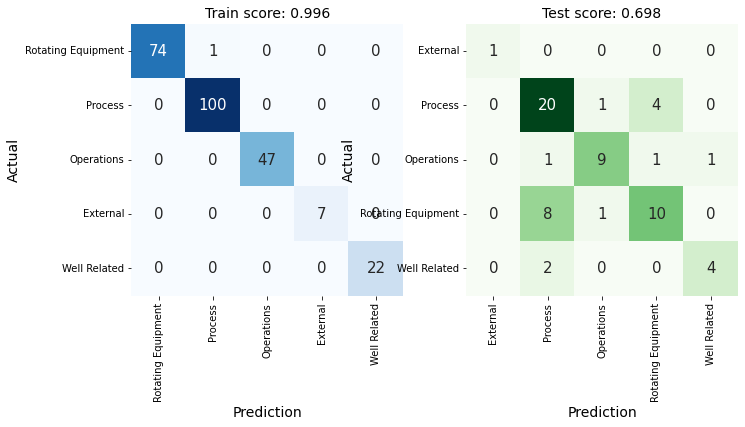

In [55]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# Using model to predict new data

In [56]:
save_model(model,'predict_category.pkl')

Model is pickled as model/predict_category.pkl


# import model

In [57]:
name = ["MP Compressor failure"]

vecs_name = [norm_sent_vector (sentence.lower(), w2v) for sentence in name]
vecs_name = np.array(vecs_name)
model.predict(vecs_name)

array(['Rotating Equipment'], dtype=object)